# Отток клиентов

Датасет содержит исторические данные о поведении клиентов и расторжении договоров с банком. Необходимо спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.

Успешным считается модель со значением F1-меры 0,59.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## 1. Подготовка данных

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import random # Для генерации заполнения пропусков в данном распределениее у tenor


# Модули моделей
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Модули работы с выборкой
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle # Для апсамлинга/даунсамплинга.
from sklearn.preprocessing import StandardScaler #Для стандартизации признаков

# Модули проверки модели
from sklearn.metrics import f1_score #Среднее гармоническое полноты и точности
from sklearn.metrics import roc_curve #ROC-кривая 
from sklearn.metrics import roc_auc_score 

In [11]:
df = pd.read_csv('datasets/churn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [12]:
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [13]:
# Проверим на дубликаты строк.

df.duplicated().sum()

0

In [14]:
# Приведем названия столбцов к нижнему регистру.

df.columns = df.columns.map(lambda x: x.lower())
df.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

In [15]:
# Значения пропущены только в столбце tenure, их около 10%, что много. Заменим их на случайные значения от 0 до 10. 
 
df['tenure'] = df['tenure'].fillna(random.randint(0, 10))
df['tenure'].value_counts()

0.0     1291
1.0      952
2.0      950
8.0      933
3.0      928
5.0      927
7.0      925
4.0      885
9.0      882
6.0      881
10.0     446
Name: tenure, dtype: int64

In [16]:
# Для анализа данных некоторые столбцы можем удалить, так как они не являются предикаторами.
# Удаляем rownumber, customerid и surname

df = df.drop(['rownumber', 'customerid', 'surname'], axis=1)

In [17]:
# Значения ряда столбцов являются категориальными, их можно заменить методом OHE.
# К таким столбцам относятся: Geography, Gender.

df = pd.get_dummies(df, drop_first=True)

Выполнена предисследовательская обработка данных, дубликаты строк не отсутсвуют; имеющиеся пропуски столбца tenure заменены на медианные значения; удалены столбцы, не влияющие на результаты модели; категориальные переменные выделены в отдельеык столбцы через прямое кодирование (OHE).

## 2. Исследование задачи

In [18]:
# Выделим предикаторы и резульативный признак.

features = df.drop(['exited'], axis=1)
target = df['exited']

In [19]:
# Приведем признаки датасета к одному масштабу.

scaler = StandardScaler()
scaler.fit(features)
features = pd.DataFrame(scaler.transform(features))

In [20]:
# Выделим из исходных данных тестовую выборку.

(features_train,
 features_test,
 target_train,
 target_test) = train_test_split(features, target, test_size=0.1, random_state=12345, stratify=target)


# Раздедим оставшиеся данные на обучающую и валидационную выборки.

(features_train,
 features_valid,
 target_train,
 target_valid) = train_test_split(features_train, target_train, test_size=0.2, random_state=12345, )


# Проверим корерктность рассплитовки.
if features_train.shape[0]+features_valid.shape[0]+features_test.shape[0] == df.shape[0]:
    print('Датасет раздлен на выборки корректно\n')
else:
    print('Датасет раздлен на выборки некорректно\n')

print('Исходный датасет включает:', df.shape[0],
      '\nОбучающая выборка включает:', features_train.shape[0], f'или {features_train.shape[0]/df.shape[0]:.0%} датасета'
      '\nВалидационная выборка включает:', features_valid.shape[0], f'или {features_valid.shape[0]/df.shape[0]:.0%} датасета'
      '\nТестовая выборка включает:', features_test.shape[0], f'или {features_test.shape[0]/df.shape[0]:.0%} датасета')

Датасет раздлен на выборки корректно

Исходный датасет включает: 10000 
Обучающая выборка включает: 7200 или 72% датасета
Валидационная выборка включает: 1800 или 18% датасета
Тестовая выборка включает: 1000 или 10% датасета


In [22]:
# Проверим стратификацию.

print('Исходный датасет:\n', (target.value_counts()/target.shape[0]).round(2))
print('Обучающая выборка:\n', (target_train.value_counts()/target_train.shape[0]).round(2))
print('Валидационная выборка:\n', (target_valid.value_counts()/target_valid.shape[0]).round(2))
print('Тестовая выборка:\n', (target_test.value_counts()/target_test.shape[0]).round(2))

Исходный датасет:
 0    0.8
1    0.2
Name: exited, dtype: float64
Обучающая выборка:
 0    0.8
1    0.2
Name: exited, dtype: float64
Валидационная выборка:
 0    0.79
1    0.21
Name: exited, dtype: float64
Тестовая выборка:
 0    0.8
1    0.2
Name: exited, dtype: float64


### 2.1 Дерево решений

In [23]:
dt_best_model = None
dt_best_result_pure = 0
best_depth = 0

for depth in range(1, 100):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    
    if result > dt_best_result_pure:
        dt_best_model = model
        best_depth = depth
        dt_best_result_pure = result

print('\nF1 лучшей модели:', dt_best_result_pure,
      '\nЕе глубина:', best_depth)


F1 лучшей модели: 0.5401709401709401 
Ее глубина: 7


### 2.2. Случайный лес

In [24]:
rf_best_model = None
rf_best_result_pure = 0
est = 0

for est in range(1, 100):
    model = RandomForestClassifier(random_state=12345, n_estimators=est)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    
    if result > rf_best_result_pure:
        rf_best_model = model
        best_est = est
        rf_best_result_pure = result

print('F1 лучшей модели:', rf_best_result_pure,
          '\nЧисло ее деревьев:', best_est)

F1 лучшей модели: 0.5427135678391959 
Число ее деревьев: 55


### 2.3. Логистическая регрессия

In [25]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
prediction = model.predict(features_valid)

lr_result_pure = f1_score(target_valid, prediction)
print("F1:", lr_result_pure)

F1: 0.28346456692913385


Датасет разбит на обучающую, валидационную и тестовую выборки, выполена проверка на корректность рассплитовки. Обучающая и валидационная выборки применены к моделям Дерева решений, Случайного леса и Логистической регрессии; в результате, метрика F1 оказывается ниже требуемого порога в 0,59 (лучший результат получен на Случайном лесу - 0,55, худший - у Логистической регрессии - 0,28).

## 3. Борьба с дисбалансом

Улучшим показатели моделей, ребалансировав данные.

### 3.1. Взвешивание классов

Обучим модели, указав параметр взвешивания классов, чтобы более редкие классы, встречающиеся в выборках имели больший вес при принятии моделью решения об отнесении его к тому или иному классу.

In [26]:
# Дерево решений со взвешенными классами.

dt_best_model_weighted = None
dt_best_result_weighted = 0
best_depth = 0

for depth in range(1, 100):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    
    if result > dt_best_result_weighted:
        dt_best_model_weighted = model
        best_depth = depth
        dt_best_result_weighted = result

print('\nF1 лучшей модели:', dt_best_result_weighted,
      '\nЕе глубина:', best_depth)


F1 лучшей модели: 0.5815899581589958 
Ее глубина: 7


Метрика F1 не достигла порогового значения (0,58 против 0,59). 

In [27]:
# Случайный лес со взвешенными классами.

rf_best_model_weighted = None
rf_best_result_weighted = 0
est = 0

for est in range(1, 100):
    model = RandomForestClassifier(random_state=12345, n_estimators=est, class_weight='balanced')
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    
    if result > rf_best_result_weighted:
        rf_best_model = model
        best_est = est
        rf_best_result_weighted = result

print('F1 лучшей модели:', rf_best_result_weighted,
      '\nЧисло ее деревьев:', best_est)

F1 лучшей модели: 0.5491525423728815 
Число ее деревьев: 35


Метрика F1 не достигла порогового значения (0,54 против 0,59).

In [28]:
# Логистическая регрессия со взвешенными классами.

model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
prediction = model.predict(features_valid)

lr_result_weighted = f1_score(target_valid, prediction)

print("F1:", lr_result_weighted)

F1: 0.5076923076923077


Метрика F1 составила 0,51, то есть по-прежнему ниже пороговых 0,59.

Все три модели - Деева решений, Случайного леса и Логистической регрессии - при испоьзовании параметра взвешивания классов, дали лучший результат, чем без него, однако, пороговое значение F1 не было достигнуто данным методом борьбы с дисбалансом в выборке.

### 3.2. Upsampling

In [30]:
# Напишем функцию для апсмплинга, которая увеличит частотность редких классов в выборке.

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [31]:
# Применим функцию апсамплинга к обучающей выборке.
# Число повторений дублирования классов (параметр repeat) возьмем как отношение классов 0 к классам 1.

repeat = (target_train.value_counts()/target_train.shape[0])
repeat = (repeat[0]/repeat[1]).astype('int')

features_upsampled, target_upsampled = upsample(features_train, target_train, repeat)

In [32]:
# Обучим Логистическую регрессию на преобразованных апсамплингом даных.

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

lr_result_upsampled = f1_score(target_valid, predicted_valid)

print("F1:", lr_result_upsampled)

F1: 0.5068493150684932


F-1 мера по-прежнему ниже порогового значения (0,51 против 0,59).

In [33]:
# Обучим Дерево решений на преобразованных апсамплингом даных.

dt_best_model_upsampled = None
dt_best_result_upsampled = 0
best_depth = 0

for depth in range(1, 100):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    
    if result > dt_best_result_upsampled:
        dt_best_model_upsampled = model
        best_depth = depth
        dt_best_result_upsampled = result

print('\nF1 лучшей модели:', dt_best_result_upsampled,
      '\nЕе глубина:', best_depth)


F1 лучшей модели: 0.6004784688995215 
Ее глубина: 7


F1-мера на данных с upsampling получилась вышк порогового значения (0,6 против требуемых 0,59).

In [35]:
# Обучим Случайный лес на преобразованных апсамплингом даных.

rf_best_model_upsampled = None
rf_best_result_upsampled = 0
est = 0

for est in range(1, 100):
    model = RandomForestClassifier(random_state=12345, n_estimators=est)
    model.fit(features_upsampled, target_upsampled)
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    
    if result > rf_best_result_upsampled:
        rf_best_model_upsampled = model
        best_est = est
        rf_best_result_upsampled = result

print('F1 лучшей модели:', rf_best_result_upsampled,
      '\nЧисло ее деревьев:', best_est)

F1 лучшей модели: 0.5844346549192365 
Число ее деревьев: 21


Метрика F1 получилась лучше, но все равно ниже поровых 0,59.

### 3.3. Downsampling

In [36]:
# Напишем функцию для даунсамплинга, которая уменьшит частотность частых классов в выборке.

def downsampling(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [37]:
# Применим функцию апсамплинга к обучающей выборке.
# Число сокращения частых классов (параметр fraction) возьмем как отношение редкого класса (1) к частому (0).

repeat = (target_train.value_counts()/target_train.shape[0])
repeat = (repeat[1]/repeat[0])


features_downsampled, target_downsampled = downsampling(features_train, target_train, repeat)

In [38]:
# Обучим Дерево решений на преобразованных даунсамплингом даных.

dt_best_model_downsampled = None
dt_best_result_downsampled = 0
best_depth = 0

for depth in range(1, 100):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    
    if result > dt_best_result_downsampled:
        dt_best_model_downsampled = model
        best_depth = depth
        dt_best_result_downsampled = result

print('\nF1 лучшей модели:', dt_best_result_downsampled,
      '\nЕе глубина:', best_depth)


F1 лучшей модели: 0.5687885010266941 
Ее глубина: 6


F-1 метрика по-прежнему недостаточно высокая (0,57 против 0,59).

In [39]:
# Обучим Случайный лес на преобразованных даунсамплингом даных.

rf_best_model_downsampled = None
rf_best_result_downsampled = 0
est = 0

for est in range(1, 100):
    model = RandomForestClassifier(random_state=12345, n_estimators=est)
    model.fit(features_downsampled, target_downsampled)
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    
    if result > rf_best_result_downsampled:
        rf_best_model_downsampled = model
        best_est = est
        rf_best_result_downsampled = result

print('F1 лучшей модели:', rf_best_result_downsampled,
      '\nЧисло ее деревьев:', best_est)

F1 лучшей модели: 0.5806451612903225 
Число ее деревьев: 84


F1-метрика достигла порогового значения 0,59.

In [40]:
# Обучим Логистическую регрессию на преобразованных даунсамплингом даных.

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
prediction = model.predict(features_valid)

lr_result_downsampled = f1_score(target_valid, predicted_valid)

print("F1:", lr_result_downsampled)

F1: 0.5068493150684932


F1-метрика не достаточно высокая (0,51 против 0,59).

In [41]:
print('Метрика F1 до борьбы с дисбалансом:')
print('F1 Дерева решений:', dt_best_result_pure.round(2))
print('F1 Случайного леса:', rf_best_result_pure.round(2))
print('F1 Логистической регрессии:', lr_result_pure.round(2))
print('')

print('Метрика F1 после взвешивания классов:')
print('F1 Дерева решений:', dt_best_result_weighted.round(2))
print('F1 Случайного леса:', rf_best_result_weighted.round(2))
print('F1 Логистической регрессии:', lr_result_weighted.round(2))
print('')

print('Метрика F1 после апсамплинга:')
print('F1 Дерева решений:', dt_best_result_upsampled.round(2))
print('F1 Случайного леса:', rf_best_result_upsampled.round(2))
print('F1 Случайного леса:', lr_result_upsampled.round(2))
print('')

print('Метрика F1 после даунсамплинга:')
print('F1 Дерева решений:', dt_best_result_downsampled.round(2))
print('F1 Случайного леса:', rf_best_result_downsampled.round(2))
print('F1 Случайного леса:', lr_result_downsampled.round(2))

Метрика F1 до борьбы с дисбалансом:
F1 Дерева решений: 0.54
F1 Случайного леса: 0.54
F1 Логистической регрессии: 0.28

Метрика F1 после взвешивания классов:
F1 Дерева решений: 0.58
F1 Случайного леса: 0.55
F1 Логистической регрессии: 0.51

Метрика F1 после апсамплинга:
F1 Дерева решений: 0.6
F1 Случайного леса: 0.58
F1 Случайного леса: 0.51

Метрика F1 после даунсамплинга:
F1 Дерева решений: 0.57
F1 Случайного леса: 0.58
F1 Случайного леса: 0.51


Таким образом, в результате преобразований обучающих данных, удалось улучшить F1 на всех трех моделях.
<br>Наилучший результат получился после апсамлинга Дерева решений (0,61) и даунсамплинга Случайного леса (0,6).

## 4. Тестирование модели

In [42]:
# Протестируем на модели Дерева решений, обученной на данных с апсамлингом.

dt_upsampled_test = dt_best_model_upsampled.predict(features_test)
print('F1 лучшей модели на тестовой выборке:', f1_score(target_test, dt_upsampled_test).round(2))

F1 лучшей модели на тестовой выборке: 0.58


In [43]:
# Протестируем на модели Случайного леса, обученной на данных с даунсамплингом.

rf_downsampled_test = rf_best_model_downsampled.predict(features_test)
print('F1 лучшей модели на тестовой выборке:', f1_score(target_test, rf_downsampled_test).round(2))

F1 лучшей модели на тестовой выборке: 0.59


Модель Случайного леса, обученная на данных с даунсамплингом показала себя лучше на тестовых данных, нежеди модель Дерева решений, обученная на данных с апсамплингом.
<pr>Признаем ее лучшей модейлью.

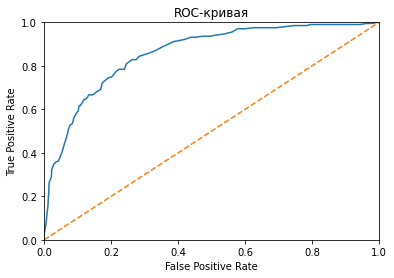

ROC-score модели: 0.8586129175288206


In [44]:
# Построим ROC-кривую модели.

probabilities_test = rf_best_model_downsampled.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
 
plt.figure()
plt.plot(fpr, tpr)
 
plt.plot([0, 1], [0, 1], linestyle='--')
 

plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('ROC-score модели:', auc_roc)

Таким образом, данные были проверены и обработаны (чек наличия дубликатов, подстановка медианных значений в пропуски, прямое кодирование количественных признаков).
<br>Модели Дерева решений, Случайного леса и Линейной регрессии на несбалансированных данных показали низкое значение F1-меры, в результате было принято решение о балансировке данных через взвешивание класов, upsampling, downsampling.
<br>Пороговой метретрики F1 при обучении удалось добиться модели Дерева решений после апсамплинга данных и модели Случайного деса после даунсамплинга данных.
<br>Однако, при проверке этих моделей на тестовой выборке, Дерево решений показало худший результат и модель Случайного леса, обученная на данных с даунсамплингом оказалась единственной, способной добиться значения F1 более 0,59.